## Import modules

In [1]:
#import standard modules
%run ../load_main.py
from WRFChemToolkit.analysis import aerosols_202 as aer, plots as pt, statistics as st, IGP as igp

#for getting only IGP data
import salem
shp_igp= salem.read_shapefile("/exports/csce/datastore/geos/users/s1878599/phd_work/IGP/gadm_data/IGP/IGP.shp")

WRFchem outputs data path is: dpath=/geos/d21/s1878599/IGP


## Create functions for calculating emissions 

In [2]:
# uniform emission rates between gas and aerosols.
def emi_unirates_fire(ds): 
    "uniforms all emissions rates from [mol km-2 hr-1] to [ug m-2 s-1]."

    #NOTE non obvious mapping (based on the fire_map in fire-emis utility): open->BIGALD;acetol -> HYAC, apin->CH10H16.
    molw ={ "co":28, "no":30,"no2":46,"so2":64,"bigalk":72,"bigene":56, "c2h4":28, "c2h5oh":46, "c2h6":30, "c3h8":44, "c3h6":42, 
            "ch2o":30, "ch3cho":44, "ch3coch3":58, "ch3oh":32, "mek":72, "toluene":92, "nh3":17,"open":98, "c10h16":136, 
           "ch3cooh":60, "cres":108, "glyald":60, "mgly":72, "acetol":74, "isop":68, "macr":70, 
            "mvk":70, "gly":72}
    gug=1e+6 #g to ug.
    km2m2=1e+6 # km2 to m2.
    hrsec=3600 #hour to sec 
    conv = gug/(km2m2*hrsec)   # ug m-2 s-1.
    dsc=ds.copy(deep=True)
    for sp in molw.keys():
        dsc["ebu_in_"+ sp]= dsc["ebu_in_"+ sp]*molw[sp]*conv  
        dsc["ebu_in_"+ sp].attrs["units"]="ug m-2 s-1"

    return dsc

# Calcualte hourly total emissions at each gridcell.
def calc_emifire(ds,sres):
    """
    Convert wrffirechemi emissions rates to hourly emissions at each grid point [Gg hour-1] based on gridcell resolution (sres).
    """
    km2m2=1e+6 # km2 to m2. sres in km need to convert in m.
    hrsec=3600 #hour to sec.
    ugGg=1e-15 #ug to Gg.
    
     # create empty datarray to be filled with total emissions.
    ds["tot_emi"]= xr.DataArray(np.zeros(ds["ebu_in_co"].shape), coords=ds.coords, dims=ds.dims)
   
    for da in ds.data_vars.values():
        if da.name.startswith("ebu_in"):
            ds[da.name]=ds[da.name]*hrsec*km2m2*(sres*sres)*ugGg   #  emissions at each gridpoint at each hour.
            ds[da.name].attrs["units"]="Gg hour-1"
            
            ds["tot_emi"]=ds["tot_emi"]+ds[da.name]  #adding to total emissions.
            
    ds["tot_emi"].attrs["units"]="Gg hour-1"
   

In [3]:
def add_lat_lon_fire(dsf):
    #Adding XLAT and XLONG to fire emissions dataset (they don't have it by default)
    datapath ='/geos/d21/s1878599/IGP/outputs/autumn/wrfout_d01_2017-10-18_00:00:00_.nc'
    ds = xr.open_dataset(datapath)
    #reshaping XLAT and LONG to ds_fire sizes.
    lat =np.resize(ds.XLAT.values,dsf.ebu_in_co.shape)
    long =np.resize(ds.XLONG.values,dsf.ebu_in_co.shape)

    #adding to ds_fire
    dsf['XLAT'] = xr.DataArray(lat, dims = dsf.dims)
    dsf['XLONG'] = xr.DataArray(long, dims = dsf.dims)

## Caclulate emissions difference

### Prepare emission difference

In [4]:
#Get anthropogenic emissions data for each season, both for base (b) and perturbed case (p).
#Files are hourly fire emissions (FINN).

fab_pth = dpath+'/inp_emiss/autumn/emi_base/wrffire*'
fap_pth = dpath+'/inp_emiss/autumn/emi_ptrb/wrffire*'
fwb_pth = dpath+'/inp_emiss/winter/emi_base/wrffire*'
fwp_pth = dpath+'/inp_emiss/winter/emi_ptrb/wrffire*'
fpmb_pth =dpath+ '/inp_emiss/premonsoon/emi_base/wrffire*'
fpmp_pth =dpath+ '/inp_emiss/premonsoon/emi_ptrb/wrffire*'
fmb_pth = dpath+ '/inp_emiss/monsoon/emi_base/wrffire*'
fmp_pth = dpath+'/inp_emiss/monsoon/emi_ptrb/wrffire*'

fab = xr.open_mfdataset(fab_pth, concat_dim='Time').sel(Time=slice(504,672)) # get period from 1 nov to 8 nov.
fap = xr.open_mfdataset(fap_pth,concat_dim='Time').sel(Time=slice(504,672))
fwb = xr.open_mfdataset(fwb_pth, concat_dim='Time').sel(Time=slice(504,672)) # get period from 22 jan to 29 jan.
fwp  =xr.open_mfdataset(fwp_pth,concat_dim='Time').sel(Time=slice(504,672))
fpmb = xr.open_mfdataset(fpmb_pth, concat_dim='Time').sel(Time=slice(504,672)) # get period from 2 may to 8 may.
fpmp = xr.open_mfdataset(fpmp_pth,concat_dim='Time').sel(Time=slice(504,672)) 
fmb = xr.open_mfdataset(fmb_pth , concat_dim='Time').sel(Time=slice(504,672)) # get period from 17 july to 24 july.
fmp = xr.open_mfdataset(fmp_pth ,concat_dim='Time').sel(Time=slice(504,672)) 

# put base and perturbed emissions in a dict by season.
emi_f={"aut":[fab,fap], "win":[fwb,fwp],"pmon":[fpmb,fpmp],"mon":[fmb,fmp]}

In [5]:
#Calculate total hourly emissions at each gridpoint [Gg hour-1]. 
for v in emi_f.values():
    for ds in v: 
        temp=emi_unirates_fire(ds)
        calc_emifire(temp,sres=20)
        ds["tot_emi"]=temp.tot_emi

### Calculate total emissions difference for the perturbed period in the whole IGP

In [6]:
emitot_igp={'pmon': {}, 'mon': {}, 'aut': {}, 'win': {}}
for s in emi_f.keys():
        add_lat_lon_fire(emi_f[s][0])
        add_lat_lon_fire(emi_f[s][1])
        v0igp=emi_f[s][0].salem.roi(shape=shp_igp)
        v1igp=emi_f[s][1].salem.roi(shape=shp_igp)
        tb= v0igp['tot_emi'].sum(dim=['Time', 'emissions_zdim_stag',"south_north","west_east"]).values
        tp= v1igp['tot_emi'].sum(dim=['Time', 'emissions_zdim_stag',"south_north","west_east"]).values
        d=tp-tb # difference Gg
        emitot_igp.update({s:d})

In [7]:
emitot_igp

{'pmon': 12.474536311513589,
 'mon': 0.12888897513263053,
 'aut': 11.606184995039769,
 'win': 1.7529921576660854}

### Calculate weighted total emissions difference for the perturbed period in the whole IGP

In [8]:
# Calculate weights (number of gridcells with emissions 2.8Mg during the simulation period).
weight_igp={'pmon': {}, 'mon': {}, 'aut': {}, 'win': {}}
for s in emi_f.keys():
        add_lat_lon_fire(emi_f[s][0])
        add_lat_lon_fire(emi_f[s][1])
        base= emi_f[s][0].salem.roi(shape=shp_igp)['tot_emi'].sum(dim=['Time', 'emissions_zdim_stag'])
        per= emi_f[s][1].salem.roi(shape=shp_igp)['tot_emi'].sum(dim=['Time', 'emissions_zdim_stag'])
        d=per-base
        w = np.count_nonzero(d.values>2.8e-3) # 2.8 Mg correspod to a rate of 0.001 g m-2 day-1.
        weight_igp.update({s:w})

# Calcualte weighted emissions.
w_emitot_igp={'pmon': {}, 'mon': {}, 'aut': {}, 'win': {}}
for s in emitot_igp.keys():
    we=emitot_igp[s]/weight_igp[s]
    w_emitot_igp.update({s:we})

In [9]:
weight_igp

{'pmon': 466, 'mon': 18, 'aut': 242, 'win': 193}

## Prepare aerosols outputs

In [10]:
#Get aerosol outputs data for each season, both for base (b) and perturbed case (p).
oab_pth=dpath+'/outputs/autumn/wrfout_d01_2017-11-01_00:00:00_.nc'
oap_pth=dpath+'/outputs/autumn/fire_prtb/wrfout_d01_2017-11-01_00:00:00_fp.nc'
owb_pth=dpath+'/outputs/winter/wrfout_d01_2018-01-22_00:00:00_.nc'
owp_pth=dpath+'/outputs/winter/fire_prtb/wrfout_d01_2018-01-22_00:00:00_fp.nc'
opmb_pth=dpath+'/outputs/premonsoon/wrfout_d01_2017-05-02_00:00:00.nc'
opmp_pth=dpath+'/outputs/premonsoon/fire_prtb/wrfout_d01_2017-05-02_00:00:00_fp.nc'
omb_pth=dpath+'/outputs/monsoon/wrfout_d01_2017-07-17_00:00:00_.nc'
omp_pth=dpath+'/outputs/monsoon/fire_prtb/wrfout_d01_2017-07-17_00:00:00_fp.nc'

oab= xr.open_mfdataset(oab_pth).sel(Time=slice(1,56)) # get period from 1 nov to 8 nov without 
oap=xr.open_mfdataset(oap_pth).sel(Time=slice(1,56))  # output perturbed from antrho
owb= xr.open_mfdataset(owb_pth).sel(Time=slice(1,56)) # get period from 22 jan to 29 nov
owp=xr.open_mfdataset(owp_pth).sel(Time=slice(1,56))  # output perturbed from antrho
opmb= xr.open_mfdataset(opmb_pth).sel(Time=slice(1,56)) # get period from 2 may to 8 may
opmp=xr.open_mfdataset(opmp_pth).sel(Time=slice(1,56))  # output perturbed from antrho
omb=xr.open_mfdataset(omb_pth).sel(Time=slice(1,56)) # get period from 17 july to 24 july
omp=xr.open_mfdataset(omp_pth).sel(Time=slice(1,56)) # output perturbed from fire

# put everything in a dict by season
sfout={"aut":[oab,oap], "win":[owb,owp],"pmon":[opmb,opmp],"mon":[omb,omp]}

In [11]:
#get aerosols.
aaer={}
for k,v in sfout.items():
    
    baer= aer.get_aerosols(v[0])
    baer.attrs=v[0].attrs
    paer= aer.get_aerosols(v[1])
    paer.attrs=v[1].attrs
    
    aaer.update({k :[baer,paer]})   

## Calculate sensitivities

In [12]:
#Create function for surface sensitivity at gridpoint ij for a specified species.

def get_s_ij(bds,pds,delta_emi,var,thres):
    """
    bds = base output.
    pds = perturbed output.
    delta_emi = total difference in emissions [Gg].
    var = variable for which calculate sensitivity.
    thres= threshold in aerosols difference for calculating senstivity  [ug m-3].
    """
    # surface total difference in concentration over sim period [ug/m3].
    diff_var = (pds[var].sum(dim ='Time')-bds[var].sum(dim ='Time'))[0, :, :]
    
    # Apply threshold and put nan to zero.
    diff_masked = diff_var.where(diff_var.values>thres) 
    diff_masked.values=np.nan_to_num(diff_masked.values, copy=False,nan=0.0, posinf=0.0, neginf=0.0)

    # compute sensitivity.
    s = diff_masked/delta_emi
    return xr.Dataset({'sty':s},coords=dict(bds.coords))
    

# calculate sensitivities for all season and put in a dict.
def sensitivity(do,de,var,thres):
    "do= output dict,de=emissions dict,var=varname thres=sesnitivity calcualtion treshold "
    
    shdfigp= salem.read_shapefile("/exports/csce/datastore/geos/users/s1878599/phd_work/IGP/gadm_data/IGP/IGP.shp")
    s={}
    for k in do.keys():
        
        sens= get_s_ij(do[k][0],do[k][1],de[k],var,thres) # calc sensitivity.
        sens.attrs=do[k][0].attrs 
        
        sens_igp = sens.salem.roi(shape=shdfigp)  # get sensitivity only for IGP area.
        s.update({k:sens_igp})

    return s

In [13]:
# calculate sensitivities for PM2.5
spm25=sensitivity(aaer,w_emitot_igp,"pm25_tot",thres=4)

In [14]:
# calculate sensitivities for POA
sPOA=sensitivity(aaer,w_emitot_igp,"pm10_POA",thres=1)

In [15]:
# calculate sensitivities for SOA
sSOA=sensitivity(aaer,w_emitot_igp,"pm10_SOA",thres=1)

In [16]:
# calculate sensitivities for OA
sOA=sensitivity(aaer,w_emitot_igp,"pm10_OA",thres=1)

## PLOTS

In [88]:
#SPATIAL PLOT FUNCTION

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.colorbar import colorbar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader

def set_formatter(axes,leftlab):
    for ax in axes:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.3, color='k', alpha=0.4, linestyle='-')
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.xlocator = mticker.FixedLocator([70,80,90])
        gl.ylocator = mticker.FixedLocator([25,30])
        gl.xlabel_style = {'size': 11,'color': 'grey'}
        gl.ylabels_right = False
        gl.ylabels_left = False
        
        if leftlab==True:
            gl.ylabels_left = True
            gl.ylocator = mticker.FixedLocator([25,30])
            gl.ylabel_style = {'size': 11,'color': 'grey'}
        
        #ax.add_feature(cfeature.COASTLINE, lw=0.5)
        #ax.add_feature(cfeature.BORDERS, lw=0.5)
        
    # get lon values only n the last ax
        if ax==axes[3]:
            gl.xlabels_bottom = True
            gl.xlocator = mticker.FixedLocator([70,80,90])
            gl.xlabel_style = {'size': 11,'color': 'grey'}
    
    
def set_admin(axes, shp_path):
    for ax,shp in zip(axes,shp_path):
            admin = list(shpreader.Reader(shp).geometries())
            # Add data from Global Administrative Areas Dataset GDAM https://gadm.org/index.html
            ax.add_geometries(admin, ccrs.PlateCarree(),
                      edgecolor='black', facecolor='none', alpha=1, lw=0.3)
            


def sensplot(lat,lon,pmds,mds,ads,wds,panels=["(b)","(e)","(h)","(k)"],vmin=None,vmax=None,title=None, label=None, leftlab=False,bar=False,axs=False, cmap="OrRd",levs=10, 
            figsize=[7, 10],format="%.2f",save=False,spath=None,name="plot",savef='pdf', dpi=100):

    fig, axes =plt.subplots(nrows=4,ncols=1,figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})
    
    igp_shp="/exports/csce/datastore/geos/users/s1878599/phd_work/IGP/gadm_data/IGP/IGP.shp"
    shp_path=(igp_shp,igp_shp,igp_shp,igp_shp)
    
    set_formatter(axes.flatten(),leftlab)
    set_admin(axes.flatten(), shp_path)
 
    #Getting values.
    
    vpm=pmds[:,:].values
    vm= mds[:,:].values
    va= ads[:,:].values 
    vw= wds[:,:].values
   
    import math
    if vmax is None:  # Get the max value in the array to plot.
        vmax =np.array([np.nanmax(vpm),np.nanmax(vm),np.nanmax(va),np.nanmax(vw)]).max() 
    if vmin is None:  # Get the max value in the array to plot.
        vmin =np.array([np.nanmin(vpm),np.nanmin(vm),np.nanmin(va),np.nanmin(vw)]).min()  
    print(vmin,vmax)
    l = np.linspace(vmin, vmax, levs)  # number of levels for which divide the bar. Customise 
    # premonsoon
    cspm=axes[0].contourf(lon,lat,vpm,transform=ccrs.PlateCarree(),cmap=cmap, vmin=vmin,vmax=vmax,levels=l,
                            extend="both")
    cspm.cmap.set_over("#FFFF00")
    cspm.cmap.set_under("#FFFFFF")
                                                 
    # monsoon
    csm=axes[1].contourf(lon,lat,vm,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax,levels=l,
                              extend="both") 
    csm.cmap.set_over("#FFFF00")
    csm.cmap.set_under("#FFFFFF")
    #autumn
    csa=axes[2].contourf(lon,lat,va,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax,levels=l,
                           extend="both")
    csa.cmap.set_over("#FFFF00")
    csa.cmap.set_under("#FFFFFF")
    #winter
    csw=axes[3].contourf(lon,lat,vw,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax,levels=l,
                           extend="both")
    csw.cmap.set_over("#FFFF00")
    csw.cmap.set_under("#FFFFFF")
    
    if axs==True:
        axes[0].text(-0.2, 0.55, 'PRE-MONSOON', va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor', fontsize=10,
        transform=axes[0].transAxes)
        axes[1].text(-0.2, 0.55, 'MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=10,
        transform=axes[1].transAxes)
        axes[2].text(-0.2, 0.55, 'POST-MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=10,
        transform=axes[2].transAxes)
        axes[3].text(-0.2, 0.55, 'WINTER', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=10,
        transform=axes[3].transAxes)
    
    
    #add panel boxes
    panels=panels
    for ax,p in zip(fig.axes,panels):
        ax.annotate(p, xy=(1, 1), xytext=(-5, -5), fontsize=12,
        xycoords='axes fraction', textcoords='offset points',
        bbox=dict(facecolor='white',edgecolor='white', alpha=0.8),
        horizontalalignment='right', verticalalignment='top')
    
    if bar==True:
    #fig.subplots_adjust(right=0.8,hspace=0.4)  
        cbar_ax = fig.add_axes([0.92, 0.1, 0.05, 0.8])  #[left, bottom, width, height]
        cbar= fig.colorbar(csw, cax=cbar_ax,pad=0.35,shrink=1, format=format)
        cbar.set_label(label,fontsize=12)
        cbar.ax.tick_params(labelsize='medium')

    if title is not None:
        axes[0].set_title(title, fontsize=12,pad=20)
    
    
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.0)
    
    #save
    if save:
        plt.savefig( spath + name +'.' + savef, format=savef, dpi=dpi, bbox_inches = "tight")
    
    fig.show()

In [83]:
#define lat lon
lon =spm25["aut"].XLONG[0,:, :]
lat =spm25["aut"].XLAT[0,:, :]

0.0 2000.0


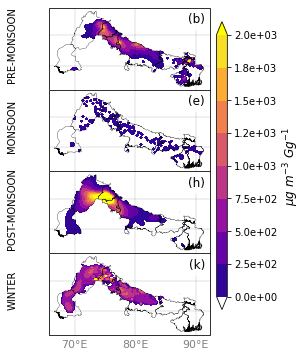

In [84]:
#PPM2.5
savepth="./"
sensplot(lat,lon,spm25["pmon"].sty,spm25["mon"].sty,spm25["aut"].sty,spm25["win"].sty,cmap="plasma",axs=True,bar=True,leftlab=False, vmax=2e3,
        levs=9,format="%.1e",figsize=[3,5],save=True, spath=savepth,name="fire_pm25",savef='png', dpi=300, label='$\mu g~m^{-3}~Gg^{-1}$')

0.0 1000.0


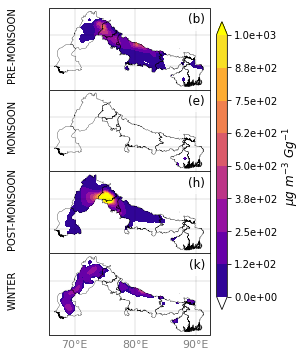

In [89]:
#POA
sensplot(lat,lon,sPOA["pmon"].sty,sPOA["mon"].sty,sPOA["aut"].sty,sPOA["win"].sty,cmap="plasma",vmax=1e3,axs=True,bar=True,leftlab=False,
        levs=9,format="%.1e",figsize=[3,5],save=True, spath=savepth,name="fire_poa",savef='png', dpi=300, label='$\mu g~m^{-3}~Gg^{-1}$')

0.0 1000.0


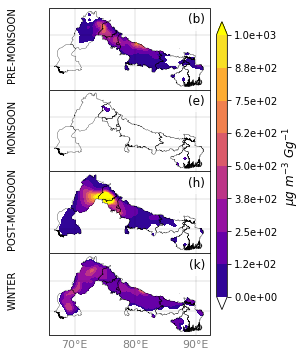

In [90]:
#OA
sensplot(lat,lon,sOA["pmon"].sty,sOA["mon"].sty,sOA["aut"].sty,sOA["win"].sty,cmap="plasma",vmax=1e3,axs=True,bar=True,leftlab=False,
        levs=9,format="%.1e",figsize=[3,5],save=True, spath=savepth,name="fire_oa",savef='png', dpi=300, label='$\mu g~m^{-3}~Gg^{-1}$')

0.0 400


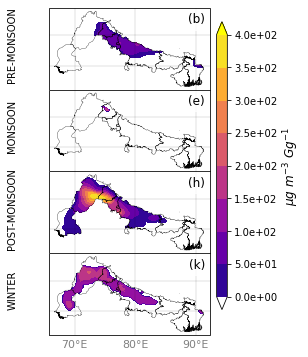

In [91]:
#SOA
sensplot(lat,lon,sSOA["pmon"].sty,sSOA["mon"].sty,sSOA["aut"].sty,sSOA["win"].sty,cmap="plasma",vmax=400,axs=True,bar=True,leftlab=False,label='$\mu g~m^{-3}~Gg^{-1}$',
        levs=9,format="%.1e",figsize=[3,5],save=True, spath=savepth,name="fire_soa",savef='png', dpi=300)